# Practice Session 06: PageRank

<font size="+1" color="blue">Nil Tomàs Plans. U214575</font>

# 1. Read host names

In [168]:
import io
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [169]:
INPUT_NODES_FILENAME = "webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "webspam_uk2007-edges.csv.gz"

In [170]:
#read the INPUT_NODES_FILENAME file into id2name, name2id, and id2label.
#definició de diccionaris
id2name={}
name2id={}
id2label={}

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:        
        id2name[int(record["nodeid"])]=record["hostname"] #id to name
        name2id[record["hostname"]]=int(record["nodeid"])#name to id
        id2label[int(record["nodeid"])]=record["label"] #id to label

      

In [171]:
# Leave as-is

print("Number of hosts: %s" % len(id2name))
print("%s: %s" % (id2name[107471], id2label[107471]))
print("%s: %s" % (id2name[3735], id2label[3735]))

Number of hosts: 114529
www.ucl.ac.uk: unlabeled
ibiza-tickets.co.uk: spam


In [172]:
num_spam=0
num_nonspam=0
num_unlabeled=0
for label in id2label.values():
    if label=="spam":
        num_spam+=1
    elif label=="nonspam":
        num_nonspam+=1
    else:
        num_unlabeled+=1

total=num_spam+num_nonspam+num_unlabeled#calculo el total fent la suma
#els percentatges de cada paràmetre serà= num*100/total
percentatge_spam=num_spam*100/total
percentatge_nonspam=num_nonspam*100/total
percentatge_unlabeled=num_unlabeled*100/total

print("Total: %s"%total)
print("Spam: %s"%num_spam,"Percentatge:%s"%percentatge_spam)
print("NonSpam: %s"%num_nonspam,"Percentatge:%s"%percentatge_nonspam)
print("Unlabeled: %s"%num_unlabeled,"Percentatge:%s"%percentatge_unlabeled)

Total: 114529
Spam: 344 Percentatge:0.3003606073570886
NonSpam: 5709 Percentatge:4.9847636843070315
Unlabeled: 108476 Percentatge:94.71487570833588


In [173]:
g = nx.DiGraph()
spammywords = ['shop', 'directory', 'credit', 'mortgage', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl']

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        source = int(record['source'])
        destination = int(record['destination'])

        condicio = False#condicio que utilitzarem per comprovar si trobem o no spammy word

        # Iterate over spammy words
        for spammy_word in spammywords:
            if spammy_word in id2name[source] or spammy_word in id2name[destination]:
                condicio = True
                break
                
        # guardem els valors de label source i de label destination
        label_source = id2label.get(source,"")
        label_dest= id2label.get(destination,"")

        # Afegim un edge si hem trobat un spammyword tant a source com a destination. Si no no.
        #A més source i la destinació han d'estar marcades com a spam o bé com a non spam.
        #SI totes aquestes condicions es compleixen, aleshores afegirem un edge
        if (condicio==True and(label_source in ["spam", "nonspam"]) and(label_dest in ["spam", "nonspam"])):            
            g.add_edge(id2name[source], id2name[destination])


print("El graf té %s nodes."%g.number_of_nodes())       

El graf té 166 nodes.


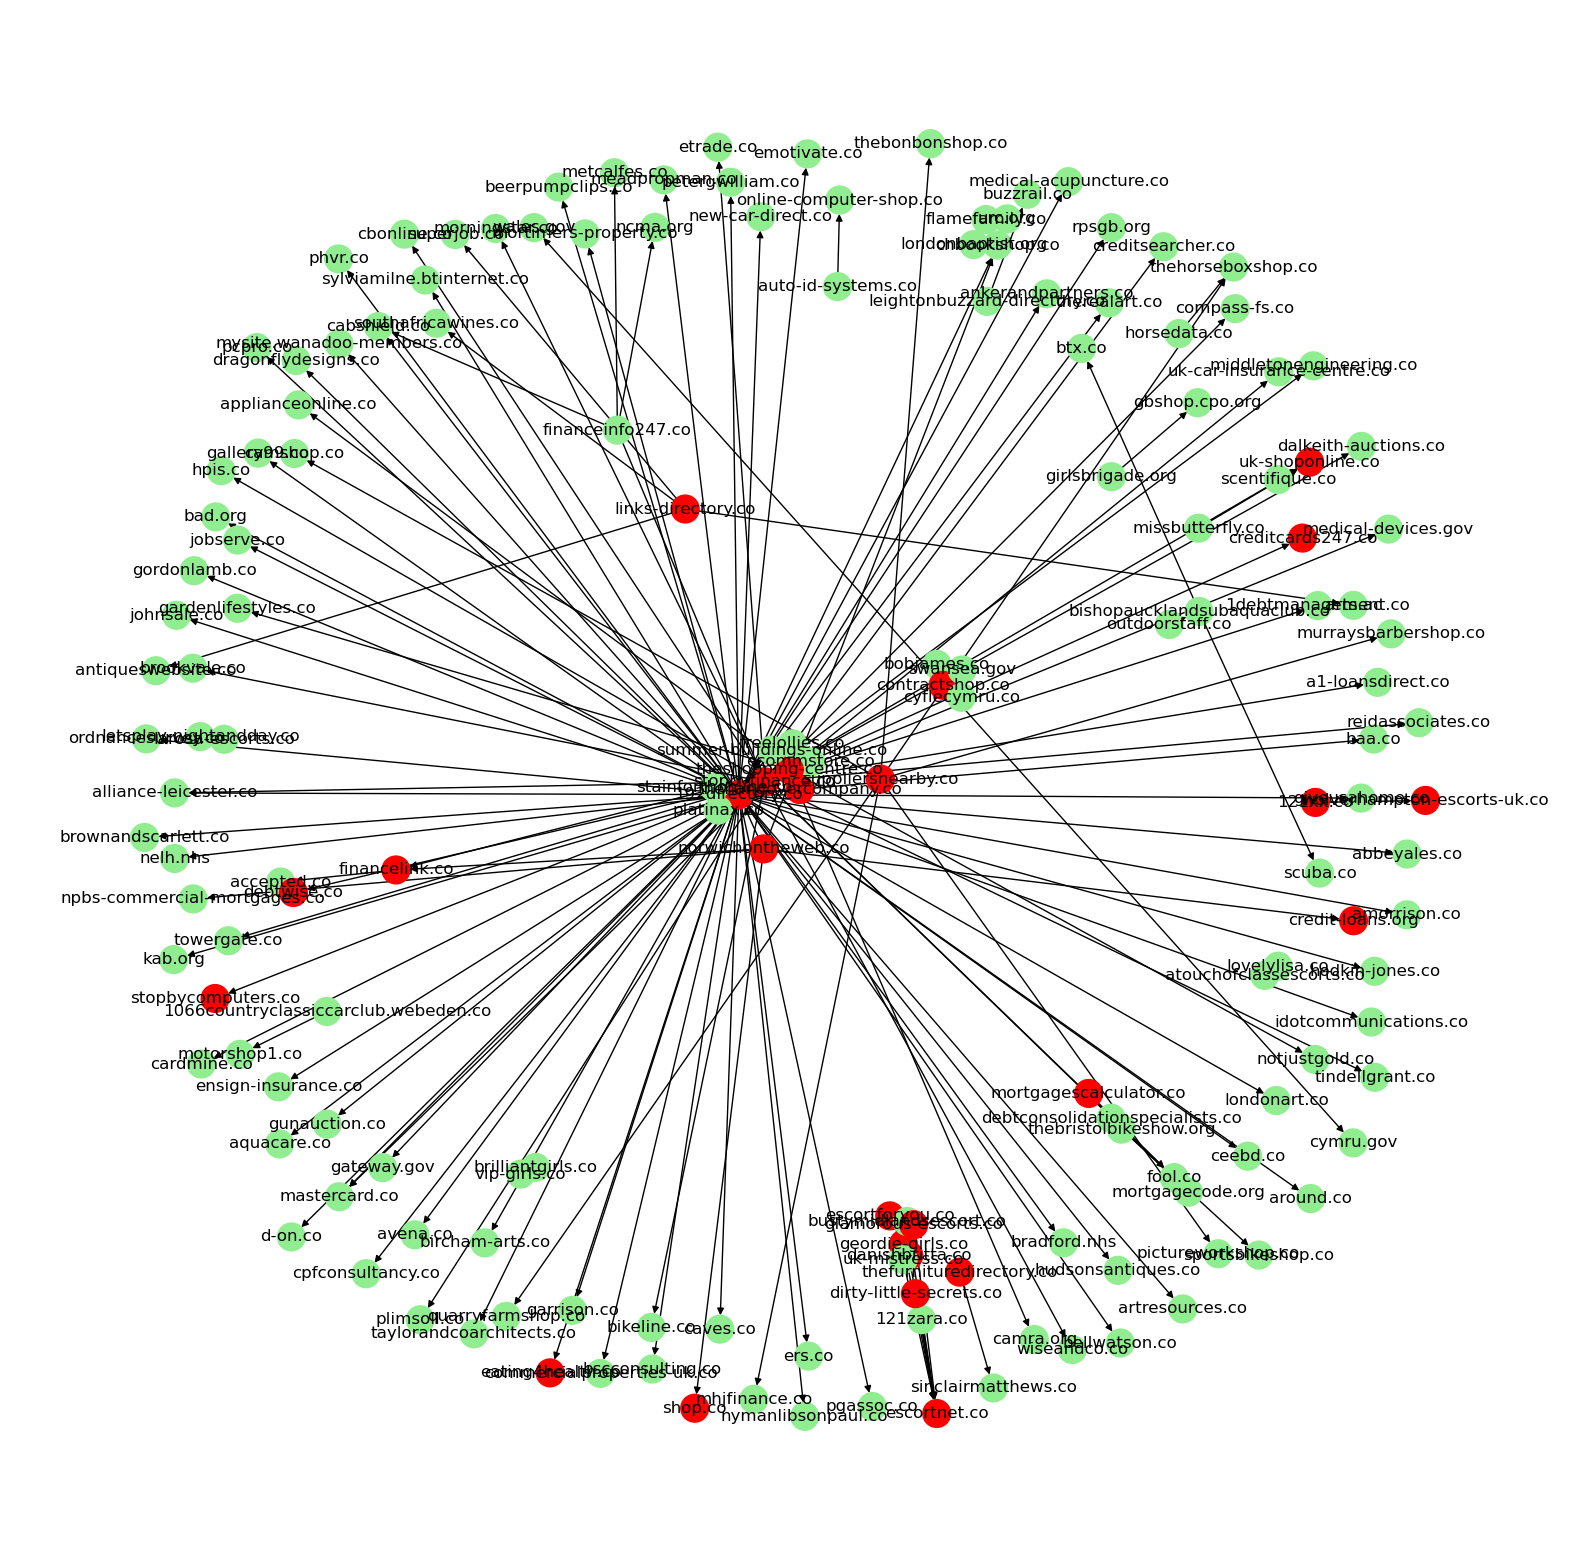

In [174]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if id2label[name2id[hostname]] == 'spam':
        colors.append('red')
    elif id2label[name2id[hostname]] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')
    
    # Shorten the hostnames to generate labels    
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label
    
# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

<font size="+1" color="blue">Puc observar que el graf està distribuit amb l'algoritme spring layout, en què els nodes que "envien" més destinacions estan al centre, i per tant la resta, la gran majoria que reben els enllaços estan a la perifèria. A més en vermell podem veure els nodes marcats com a spam i els verd com a no spam</font>

# 2. Compute the degree of each node

In [175]:
# Leave this code as-is

id2degree = {}
N = len(id2name)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [176]:
#definim el diccionari i la llargada N
id2degree = {}
N = len(id2name)

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        clau=int(record["source"])
        if clau in id2degree:#si el valor int de source està definida ja com una clau al diccionari, li sumem 1
            id2degree[clau]+=1
        else:
            id2degree[clau]=1 #si no la inicialitzem
                   
for nodeid in range(N):#comprovem que tots els nodes estiguin al diccionari
    if nodeid not in id2degree:
        id2degree[nodeid] = 0

In [177]:
# Leave this cell as-is

for nodeid in [107471, 3735, 48842]:
    print("%s: degree %d" % (id2name[nodeid], id2degree[nodeid]))

www.ucl.ac.uk: degree 1378
ibiza-tickets.co.uk: degree 1
www.financelink.co.uk: degree 5


# 3. Compute PageRank

In [178]:
# Leave this cell as-is

ITERATIONS = 20
ALPHA = 0.92

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

In [200]:
#inicialitzem pageranks
pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N
N = len(pagerank)#assignem a N la llargada del pagerank

for iteration in range(ITERATIONS):
    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
        for record in reader:
            #assignem valors a les variables source i destination
            source = int(record['source'])
            destination = int(record['destination'])
            out_degree = id2degree[source]  # Out-degree of the source node

            # Tot seguit actialitzo el page rang auxiliar de la destinació, tot sumalt-li el pagerank[source] entre el degree de sortida
            pagerank_aux[destination] += pagerank[source] / out_degree

    for vertex in range(N):
        # actualitzem el pagerank de cada vertex amb la seva formula alpha x pagerank_aux + (1.0-alpha) x (1.0/N).
        pagerank[vertex] = ALPHA * pagerank_aux[vertex] + (1.0 - ALPHA) / N

    # normalitzem el pagerank
    total = sum(pagerank)#calculem el pagerank_total
    for node in range(N):# i a cada iteració calculem el de cada node
        pagerank[node] /= total

    #tot seguit inicialitzem delta d 
    D = sum(abs(pagerank[vertex] - pagerank_aux[vertex]) for vertex in range(N))
    print(f"Delta: {D:.4f}")

    #reiniciem el pagerank aux a 0.0 per a la pròxima iteració
    pagerank_aux = [0.0] * N

Iteration 1 of 20
Delta: 0.4311
Iteration 2 of 20
Delta: 0.1859
Iteration 3 of 20
Delta: 0.1636
Iteration 4 of 20
Delta: 0.1437
Iteration 5 of 20
Delta: 0.1387
Iteration 6 of 20
Delta: 0.1334
Iteration 7 of 20
Delta: 0.1313
Iteration 8 of 20
Delta: 0.1291
Iteration 9 of 20
Delta: 0.1279
Iteration 10 of 20
Delta: 0.1266
Iteration 11 of 20
Delta: 0.1258
Iteration 12 of 20
Delta: 0.1250
Iteration 13 of 20
Delta: 0.1243
Iteration 14 of 20
Delta: 0.1237
Iteration 15 of 20
Delta: 0.1231
Iteration 16 of 20
Delta: 0.1225
Iteration 17 of 20
Delta: 0.1220
Iteration 18 of 20
Delta: 0.1214
Iteration 19 of 20
Delta: 0.1209
Iteration 20 of 20
Delta: 0.1203


# 4. Nodes with largest values of PageRank

In [181]:
hosts_by_pagerank = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)

# agafem nomes 20 top hosts amb major PageRank
top_20 = hosts_by_pagerank[:20]

# imprimim el top 20 amb els noms i pageranks
for i, (index, pagerank) in enumerate(top_20):
    nom = id2name[index]
    print(f"Top {i+1}: {nom} i Page Rank: {pagerank:.6f}")

Top 1: www.opsi.gov.uk i Page Rank: 0.006942
Top 2: www.ico.gov.uk i Page Rank: 0.004037
Top 3: www.adobe.co.uk i Page Rank: 0.003487
Top 4: www.dti.gov.uk i Page Rank: 0.003291
Top 5: www.defra.gov.uk i Page Rank: 0.003166
Top 6: www.kelkoo.co.uk i Page Rank: 0.002978
Top 7: www.communities.gov.uk i Page Rank: 0.002760
Top 8: www.direct.gov.uk i Page Rank: 0.002752
Top 9: www.dfes.gov.uk i Page Rank: 0.002621
Top 10: shopping.kelkoo.co.uk i Page Rank: 0.002524
Top 11: www.aa-roundabout.org.uk i Page Rank: 0.002520
Top 12: www.alcoholics-anonymous.org.uk i Page Rank: 0.002388
Top 13: www.dh.gov.uk i Page Rank: 0.002234
Top 14: www.hmso.gov.uk i Page Rank: 0.002098
Top 15: news.bbc.co.uk i Page Rank: 0.002051
Top 16: www.fsa.gov.uk i Page Rank: 0.002030
Top 17: www.nationalrail.co.uk i Page Rank: 0.001973
Top 18: www.homeoffice.gov.uk i Page Rank: 0.001907
Top 19: www.dwp.gov.uk i Page Rank: 0.001828
Top 20: www.hse.gov.uk i Page Rank: 0.001809


<font size="+1" color="blue">
1) Crec que aquestes són les pàgines web amb més pagerank, ja que són les més importants i per tant les que es visiten més, com podrien ser webs governamentals. 
De webs governamentals, n'hi han aproximadament un 65% (13 de 20), de comercials un 20% (4 de 20) i d educació un 15% (3 de 20)
</font>

# 5. Run non-spam PageRank

In [182]:
#code to compute id2nsdegree (ns stands for no-spam).
id2nsdegree={}#defineixo diccionari

# inicialitzo id2nsdegree a 0 a cada iteració
for i in range(N):
    id2nsdegree[i] = 0 

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        source = int(record['source'])
        destination = int(record['destination'])
        
        #guardem els valors de les claus de source i destination en les respectives variables
        source_val = id2label.get(source, "")
        destination_val = id2label.get(destination, "")

        #Si comprovem que els valors de source i destination siguin els dos diferents a spam, aleshores
        if  destination_val != "spam" and source_val != "spam":
            # Augmentem el grau en +1
            id2nsdegree[source] += 1

In [183]:
# Leave this cell as-is

for nodeid in [107471, 1469, 48842]:
    print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

www.ucl.ac.uk: normal degree 1378 nospam degree 1378
candycaine.skinthesun.co.uk: normal degree 22 nospam degree 20
www.financelink.co.uk: normal degree 5 nospam degree 0


In [194]:
#com
nspagerank = [1.0/N] * N
nspagerank_aux = [0.0] * N
N = len(nspagerank)#assignem a N la llargada del pagerank

for iteration in range(ITERATIONS):
    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
        for record in reader:
            #assignem valors a les variables source i destination
            source = int(record['source'])
            destination = int(record['destination'])
            out_degree = id2nsdegree[source]  # Out-degree of the source node

            # Tot seguit actialitzo el page rang auxiliar de la destinació, tot sumalt-li el pagerank[source] entre el degree de sortida
            if out_degree!=0:
                nspagerank_aux[destination] += nspagerank[source] / out_degree

    for vertex in range(N):
        # actualitzem el pagerank de cada vertex amb la seva formula alpha x pagerank_aux + (1.0-alpha) x (1.0/N).
        nspagerank[vertex] = ALPHA * nspagerank_aux[vertex] + (1.0 - ALPHA) / N

    # normalitzem el ns pagerank
    total = sum(nspagerank)#calculem el pagerank_total
    for node in range(N):# i a cada iteració calculem el de cada node
        nspagerank[node] /= total

    #tot seguit inicialitzem delta d 
    D = sum(abs(nspagerank[vertex] - nspagerank_aux[vertex]) for vertex in range(N))
    print(f"Delta: {D:.4f}")

    #reiniciem el ns pagerank aux a 0.0 per a la pròxima iteració
    nspagerank_aux = [0.0] * N

Iteration 1 of 20
Delta: 0.4315
Iteration 2 of 20
Delta: 0.1860
Iteration 3 of 20
Delta: 0.1635
Iteration 4 of 20
Delta: 0.1437
Iteration 5 of 20
Delta: 0.1387
Iteration 6 of 20
Delta: 0.1334
Iteration 7 of 20
Delta: 0.1313
Iteration 8 of 20
Delta: 0.1290
Iteration 9 of 20
Delta: 0.1278
Iteration 10 of 20
Delta: 0.1265
Iteration 11 of 20
Delta: 0.1257
Iteration 12 of 20
Delta: 0.1249
Iteration 13 of 20
Delta: 0.1242
Iteration 14 of 20
Delta: 0.1236
Iteration 15 of 20
Delta: 0.1230
Iteration 16 of 20
Delta: 0.1224
Iteration 17 of 20
Delta: 0.1219
Iteration 18 of 20
Delta: 0.1213
Iteration 19 of 20
Delta: 0.1208
Iteration 20 of 20
Delta: 0.1202


In [190]:

hosts_by_nspagerank = sorted(enumerate(nspagerank), key=lambda x: x[1], reverse=True)

# # agafem nomes 20 top hosts amb major nsPageRank
top_20 = hosts_by_nspagerank[:20]

# imprimim el top 20 amb els noms i nspageranks
for i, (index, nspagerank_value) in enumerate(top_20):
    nom = id2name[index]
    print(f"Top {i+1}: {nom} i noSpam Page Rank: {nspagerank_value:.6f}")

Top 1: www.opsi.gov.uk i noSpam Page Rank: 0.006935
Top 2: www.ico.gov.uk i noSpam Page Rank: 0.004029
Top 3: www.adobe.co.uk i noSpam Page Rank: 0.003482
Top 4: www.dti.gov.uk i noSpam Page Rank: 0.003288
Top 5: www.defra.gov.uk i noSpam Page Rank: 0.003160
Top 6: www.kelkoo.co.uk i noSpam Page Rank: 0.002977
Top 7: www.communities.gov.uk i noSpam Page Rank: 0.002758
Top 8: www.direct.gov.uk i noSpam Page Rank: 0.002748
Top 9: www.dfes.gov.uk i noSpam Page Rank: 0.002619
Top 10: shopping.kelkoo.co.uk i noSpam Page Rank: 0.002523
Top 11: www.aa-roundabout.org.uk i noSpam Page Rank: 0.002517
Top 12: www.alcoholics-anonymous.org.uk i noSpam Page Rank: 0.002386
Top 13: www.dh.gov.uk i noSpam Page Rank: 0.002235
Top 14: www.hmso.gov.uk i noSpam Page Rank: 0.002097
Top 15: news.bbc.co.uk i noSpam Page Rank: 0.002049
Top 16: www.fsa.gov.uk i noSpam Page Rank: 0.002027
Top 17: www.nationalrail.co.uk i noSpam Page Rank: 0.001970
Top 18: www.homeoffice.gov.uk i noSpam Page Rank: 0.001905
Top 19

<font size="+1" color="blue">Puc observar que l ordre dels hosts és el mateix, però el no-Spam Page Rank és mínimament diferent. És una mica major al PageRank que al no-Spam Page Rank</font>

# 6. Compute spam gain

In [205]:
host = []#creem la llista amb els hosts

for i in range(N):#a cada iteració anem afegint a la llista  els noms, gain, el page rank, entre d'altres
    hostname = id2name[i]
    label = id2label.get(i, "")
    if nspagerank[i] != 0:#comprovem que el nspagerank[i] sigui diferent a 0, ja que si no la divisió no es pot fer
        gain = pagerank[i] / nspagerank[i]
    else: gain=0 
    _pagerank = pagerank[i]
    _nspagerank = nspagerank[i]
    
    host.append((hostname, label, gain, _pagerank, _nspagerank))#afegim els valors a la llista

# ordenem els hosts amb la funció sorted
host_ordenats = sorted(host, key=lambda x: x[2], reverse=True)

# imprimeixo els top 30 amb major spam gain
for i, (hostname, label, gain, _pagerank, _nspagerank) in enumerate(host_ordenats[:30]):
    print(f"Top {i+1} Host: {hostname}")
    print(f"   Spam/NoSpam Label: {label}")
    print(f"   Gain: {gain:.2f}")
    print(f"   PageRank: {_pagerank:.2e}")
    print(f"   No-Spam PageRank: {_nspagerank:.2e}")
    print()

Top 1 Host: www.aili.co.uk
   Spam/NoSpam Label: unlabeled
   Gain: 116.08
   PageRank: 1.12e-04
   No-Spam PageRank: 9.64e-07

Top 2 Host: www.into.demon.co.uk
   Spam/NoSpam Label: spam
   Gain: 30.80
   PageRank: 1.01e-04
   No-Spam PageRank: 3.27e-06

Top 3 Host: sport.uk-shoponline.co.uk
   Spam/NoSpam Label: unlabeled
   Gain: 14.32
   PageRank: 1.15e-05
   No-Spam PageRank: 8.00e-07

Top 4 Host: hosting3.123-reg.co.uk
   Spam/NoSpam Label: spam
   Gain: 9.82
   PageRank: 7.80e-06
   No-Spam PageRank: 7.94e-07

Top 5 Host: www.mercurywd.co.uk
   Spam/NoSpam Label: spam
   Gain: 4.42
   PageRank: 1.19e-05
   No-Spam PageRank: 2.69e-06

Top 6 Host: www.phones4uk.co.uk
   Spam/NoSpam Label: unlabeled
   Gain: 4.30
   PageRank: 6.32e-06
   No-Spam PageRank: 1.47e-06

Top 7 Host: www.funkidry.co.uk
   Spam/NoSpam Label: unlabeled
   Gain: 3.36
   PageRank: 3.78e-06
   No-Spam PageRank: 1.12e-06

Top 8 Host: www.timcointernet.co.uk
   Spam/NoSpam Label: spam
   Gain: 3.13
   PageRank: 

<font size="+1" color="blue">Podem observar que aquesta llista ens proporciona un ordre de les webs que són més fiables i segures, ja que dividim el coeficient de no-spam (alt en webs fiables) entre el spam(baix en webs fiables), per tant contindrà un baix nivell de spam, com podrien ser enllaços d apostes, entre d'altres. </font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>